In [ ]:
# Installation des bibliothèques nécessaires - une par une
!pip install langchain
!pip install langchain-community
!pip install pypdf  # Installer pypdf explicitement
!pip install PyPDF2  # Installer aussi PyPDF2 pour être sûr
!pip install sentence-transformers
!pip install faiss-cpu
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install rouge-score
!pip install nltk
!pip install bert-score
!pip install chromadb
!pip install torch
!pip install accelerate
!pip install matplotlib
!pip install scikit-learn
!pip install pdfminer.six

# Imports généraux
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import torch
import nltk
from IPython.display import clear_output

# NLTK downloads
nltk.download('punkt')

# Imports pour chargement et préparation des documents
try:
    from pypdf import PdfReader as PyPdfReader  # Essayons d'abord pypdf
except ImportError:
    from PyPDF2 import PdfReader as PyPdfReader  # Sinon, utilisons PyPDF2

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, PDFMinerLoader

# Imports pour embeddings et stockage vectoriel
from sentence_transformers import SentenceTransformer
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM,
    T5ForConditionalGeneration, BartForConditionalGeneration,
    pipeline as hf_pipeline
)
import torch.nn.functional as F
from langchain_community.vectorstores import FAISS, Chroma

# Imports pour retrieval
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_community.llms import HuggingFacePipeline
from langchain_community.retrievers import TFIDFRetriever
from sklearn.feature_extraction.text import TfidfVectorizer

# Imports pour génération et évaluation
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
import evaluate
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Définir le dossier de données
data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_pdf_with_pypdf(pdf_path):
    try:
        reader = PyPdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
        return text
    except Exception as e:
        print(f"Erreur avec PyPdfReader: {e}")
        return ""

def load_pdf_with_langchain(pdf_path):
    try:
        loader = PyPDFLoader(pdf_path)
        pages = loader.load()
        text = ""
        for page in pages:
            text += page.page_content + "\n"
        return text
    except Exception as e:
        print(f"Erreur avec PyPDFLoader: {e}")
        return ""

def load_pdf_with_pdfminer(pdf_path):
    try:
        loader = PDFMinerLoader(pdf_path)
        documents = loader.load()
        text = ""
        for doc in documents:
            text += doc.page_content + "\n"
        return text
    except Exception as e:
        print(f"Erreur avec PDFMinerLoader: {e}")
        return ""

# Chargement des documents
pdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.pdf')]
documents = []

# Vérifier si des PDFs sont disponibles
if not pdf_files:
    print(f"Aucun fichier PDF trouvé dans le dossier {data_folder}.")
    # Créons un petit exemple pour pouvoir continuer
    sample_texts = [
        "Ceci est un exemple de document pour tester le pipeline RAG.",
        "Ce texte ne contient pas d'informations réelles mais permet de tester le système.",
        "Dans un vrai scénario, vous utiliseriez des documents PDF chargés depuis le dossier data."
    ]

    # Découper les exemples
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
    )
    for text in sample_texts:
        documents.extend(text_splitter.split_text(text))
else:
    # Charger et découper les documents
    successful_loads = 0

    for pdf_path in pdf_files:
        print(f"\nTraitement de {pdf_path}")

        # Tester les trois méthodes de chargement
        text1 = load_pdf_with_pypdf(pdf_path)
        text2 = load_pdf_with_langchain(pdf_path)
        text3 = load_pdf_with_pdfminer(pdf_path)

        # Afficher les longueurs des textes extraits
        if text1: print(f"Longueur PyPdf: {len(text1)} caractères")
        if text2: print(f"Longueur LangChain: {len(text2)} caractères")
        if text3: print(f"Longueur PDFMiner: {len(text3)} caractères")

        # Utiliser la méthode qui a extrait le plus de texte
        all_texts = [t for t in [text1, text2, text3] if t]
        if all_texts:
            text = max(all_texts, key=len)

            # Découpage du texte
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len,
            )
            chunks = text_splitter.split_text(text)
            documents.extend(chunks)
            successful_loads += 1
            print(f"✓ Document chargé avec succès: {len(chunks)} chunks extraits")
        else:
            print(f"❌ Échec du chargement de {pdf_path} avec toutes les méthodes")

    print(f"\n{successful_loads}/{len(pdf_files)} documents chargés avec succès")

# Si aucun document n'a été chargé, créer un exemple
if not documents:
    print("Aucun document n'a pu être chargé. Création d'exemples...")
    documents = [
        "Ceci est un exemple de document pour tester le pipeline RAG sans données réelles.",
        "Les actifs numériques représentent une nouvelle classe d'actifs basée sur la technologie blockchain.",
        "La réglementation des actifs numériques varie considérablement selon les juridictions.",
        "La diligence raisonnable dans le domaine des crypto-monnaies nécessite une expertise technique.",
        "Les risques liés aux actifs numériques incluent la volatilité, les hacks et l'incertitude réglementaire."
    ]

print(f"\nNombre total de chunks: {len(documents)}")

# Afficher quelques exemples de chunks pour vérification
for i in range(min(3, len(documents))):
    print(f"\nChunk {i}:\n{documents[i][:200]}...")


Traitement de data/1110830.1.0 Introduction to Digital Assets for Institutional Investors_FINAL_0.pdf
Longueur PyPdf: 36342 caractères
Longueur LangChain: 36341 caractères
Longueur PDFMiner: 36802 caractères
✓ Document chargé avec succès: 47 chunks extraits

Traitement de data/108364 PLE_Digital Assets_Deck 290724.pdf
Longueur PyPdf: 15428 caractères
Longueur LangChain: 15426 caractères
Longueur PDFMiner: 15909 caractères
✓ Document chargé avec succès: 22 chunks extraits

Traitement de data/Operational-Due-Diligence-on-Digital-Assets.pdf
Longueur PyPdf: 30233 caractères
Longueur LangChain: 30193 caractères
Longueur PDFMiner: 30723 caractères
✓ Document chargé avec succès: 41 chunks extraits

Traitement de data/mpdf.pdf
Longueur PyPdf: 13527 caractères
Longueur LangChain: 13527 caractères
Longueur PDFMiner: 14041 caractères
✓ Document chargé avec succès: 18 chunks extraits

Traitement de data/FTI+Technology+-+Decentralized+Due+Diligence.pdf
Longueur PyPdf: 16824 caractères
Longueur Lan

Longueur PyPdf: 26929 caractères
Longueur LangChain: 26923 caractères
Longueur PDFMiner: 27124 caractères
✓ Document chargé avec succès: 36 chunks extraits

Traitement de data/WEF_Digital_Assets_Regulation_2024.pdf
Longueur PyPdf: 127459 caractères
Longueur LangChain: 127453 caractères
Longueur PDFMiner: 128453 caractères
✓ Document chargé avec succès: 167 chunks extraits

Traitement de data/cravath-bringing-blockchain-due-diligence-into-focus-102024_vb-002.pdf
Longueur PyPdf: 33684 caractères
Longueur LangChain: 33680 caractères
Longueur PDFMiner: 34136 caractères
✓ Document chargé avec succès: 46 chunks extraits

Traitement de data/guide-to-the-vetting-of-digital-asset-and-digital-asset-exchanges.pdf
Longueur PyPdf: 27836 caractères
Longueur LangChain: 27794 caractères
Longueur PDFMiner: 28196 caractères
✓ Document chargé avec succès: 39 chunks extraits

Traitement de data/guide-to-regulation-on-cryptocurrency-and-digital-token.pdf
Longueur PyPdf: 62407 caractères
Longueur LangChain:

In [ ]:
# Méthode 1: Embeddings avec SentenceTransformer
def get_sentence_transformer_embeddings(texts, model_name="all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts)
    return embeddings

# Méthode 2: Embeddings avec HuggingFace via LangChain
def get_huggingface_embeddings(texts, model_name="sentence-transformers/all-mpnet-base-v2"):
    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    return [embeddings.embed_query(text) for text in texts]

# Méthode 3: Embeddings avec BERT directement
def get_bert_embeddings(texts, model_name="bert-base-uncased"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for text in texts:
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Utiliser la représentation du token [CLS]
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())

    return embeddings

# Échantillon pour évaluation
sample_docs = documents[:5]

# Obtenir des embeddings avec les différentes méthodes
embeddings1 = get_sentence_transformer_embeddings(sample_docs)
embeddings2 = get_huggingface_embeddings(sample_docs)
embeddings3 = get_bert_embeddings(sample_docs)

# Évaluation: comparer les dimensions et les normes des vecteurs
print(f"SentenceTransformer: dimensions {embeddings1.shape}, norme moyenne: {np.mean(np.linalg.norm(embeddings1, axis=1))}")
print(f"HuggingFace LangChain: dimensions {np.array(embeddings2).shape}, norme moyenne: {np.mean(np.linalg.norm(np.array(embeddings2), axis=1))}")
print(f"BERT direct: dimensions {np.array(embeddings3).shape}, norme moyenne: {np.mean(np.linalg.norm(np.array(embeddings3), axis=1))}")

# Choisir la méthode pour créer la base vectorielle complète (SentenceTransformer est souvent le meilleur compromis)
embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Créer trois types de bases vectorielles
# 1. FAISS
vectorstore_faiss = FAISS.from_texts(documents, embeddings_model)

# 2. Chroma
vectorstore_chroma = Chroma.from_texts(documents, embeddings_model)

# 3. FAISS avec un modèle MPNet plus performant
embeddings_model_mpnet = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vectorstore_faiss_mpnet = FAISS.from_texts(documents, embeddings_model_mpnet)

# Test de récupération pour évaluer les différentes bases vectorielles
test_query = "Quelle est l'idée principale de ce document?"
results_faiss = vectorstore_faiss.similarity_search(test_query, k=3)
results_chroma = vectorstore_chroma.similarity_search(test_query, k=3)
results_faiss_mpnet = vectorstore_faiss_mpnet.similarity_search(test_query, k=3)

# Comparer les résultats (évaluation)
print("\nRésultats FAISS (MiniLM):")
for i, doc in enumerate(results_faiss):
    print(f"{i+1}. {doc.page_content[:100]}...")

print("\nRésultats Chroma (MiniLM):")
for i, doc in enumerate(results_chroma):
    print(f"{i+1}. {doc.page_content[:100]}...")

print("\nRésultats FAISS (MPNet):")
for i, doc in enumerate(results_faiss_mpnet):
    print(f"{i+1}. {doc.page_content[:100]}...")

# Calculer le chevauchement entre les résultats des différentes méthodes
overlap_faiss_chroma = len(set([d.page_content for d in results_faiss]) & set([d.page_content for d in results_chroma]))
overlap_faiss_mpnet = len(set([d.page_content for d in results_faiss]) & set([d.page_content for d in results_faiss_mpnet]))

print(f"\nChevauchement FAISS-Chroma: {overlap_faiss_chroma}/3")
print(f"Chevauchement FAISS-MPNet: {overlap_faiss_mpnet}/3")

# Sauvegarde de la base vectorielle pour utilisation ultérieure
vectorstore_faiss.save_local("faiss_index")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-3-a9f7bef0809a>:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

SentenceTransformer: dimensions (5, 384), norme moyenne: 1.0
HuggingFace LangChain: dimensions (5, 768), norme moyenne: 0.9999999654262943
BERT direct: dimensions (5, 768), norme moyenne: 15.228708267211914

Résultats FAISS (MiniLM):
1. No responsibility or liability can be accepted by any member of LSEG nor their respective directors,...
2. Methods:  the  research  was  carried  out  with  a  combination  of  cognition 

techniques of vari...
3. of a basic asset and related rights, not on its form, unless the form changes the essential 

nature...

Résultats Chroma (MiniLM):
1. No responsibility or liability can be accepted by any member of LSEG nor their respective directors,...
2. Methods:  the  research  was  carried  out  with  a  combination  of  cognition 

techniques of vari...
3. of a basic asset and related rights, not on its form, unless the form changes the essential 

nature...

Résultats FAISS (MPNet):
1. Organizational documents

In this space, a target’s organizational 

In [6]:
from langchain_community.retrievers import TFIDFRetriever
from sklearn.feature_extraction.text import TfidfVectorizer

# Méthode 1: Retrieval avec FAISS
retriever_faiss = vectorstore_faiss.as_retriever(search_kwargs={"k": 4})

# Méthode 2: Retrieval basé sur TF-IDF
tfidf_retriever = TFIDFRetriever.from_texts(documents, k=4)

# Méthode 3: FAISS avec MPNet (au lieu de la compression contextuelle)
retriever_faiss_mpnet = vectorstore_faiss_mpnet.as_retriever(search_kwargs={"k": 4})

# Test et évaluation des différentes méthodes de retrieval
test_queries = [
    "Résumez les points principaux du document",
    "Quelles sont les conclusions du document?",
    "Expliquez le concept central abordé dans le texte"
]

# Fonction pour évaluer la diversité des chunks retournés
def evaluate_diversity(chunks):
    # Calculer la similarité TF-IDF entre les chunks
    tfidf = TfidfVectorizer().fit_transform([chunk.page_content for chunk in chunks])
    similarity_matrix = (tfidf * tfidf.T).toarray()
    # Moyenne des similarités hors diagonale
    n = similarity_matrix.shape[0]
    similarity_sum = np.sum(similarity_matrix) - n  # Soustraire les valeurs de la diagonale (toujours 1)
    avg_similarity = similarity_sum / (n*n - n) if n > 1 else 0
    return 1 - avg_similarity  # Plus la valeur est élevée, plus les chunks sont diversifiés

# Évaluer les retrievers
retrieval_results = {}

for query in test_queries:
    print(f"\nTest de la requête: '{query}'")

    # Récupérer les résultats de chaque retriever
    faiss_docs = retriever_faiss.get_relevant_documents(query)
    tfidf_docs = tfidf_retriever.get_relevant_documents(query)
    mpnet_docs = retriever_faiss_mpnet.get_relevant_documents(query)

    # Stocker les résultats
    retrieval_results[query] = {
        "faiss": faiss_docs,
        "tfidf": tfidf_docs,
        "mpnet": mpnet_docs
    }

    # Évaluation 1: Longueur moyenne des chunks
    avg_len_faiss = np.mean([len(doc.page_content) for doc in faiss_docs])
    avg_len_tfidf = np.mean([len(doc.page_content) for doc in tfidf_docs])
    avg_len_mpnet = np.mean([len(doc.page_content) for doc in mpnet_docs])

    print(f"Longueur moyenne FAISS (MiniLM): {avg_len_faiss:.1f} caractères")
    print(f"Longueur moyenne TF-IDF: {avg_len_tfidf:.1f} caractères")
    print(f"Longueur moyenne FAISS (MPNet): {avg_len_mpnet:.1f} caractères")

    # Évaluation 2: Diversité des chunks
    diversity_faiss = evaluate_diversity(faiss_docs)
    diversity_tfidf = evaluate_diversity(tfidf_docs)
    diversity_mpnet = evaluate_diversity(mpnet_docs)

    print(f"Diversité FAISS (MiniLM): {diversity_faiss:.3f}")
    print(f"Diversité TF-IDF: {diversity_tfidf:.3f}")
    print(f"Diversité FAISS (MPNet): {diversity_mpnet:.3f}")

    # Afficher le premier résultat de chaque méthode
    print(f"\nPremier résultat FAISS (MiniLM): {faiss_docs[0].page_content[:150]}...")
    print(f"\nPremier résultat TF-IDF: {tfidf_docs[0].page_content[:150]}...")
    print(f"\nPremier résultat FAISS (MPNet): {mpnet_docs[0].page_content[:150]}...")

# Trouver le meilleur retriever basé sur la diversité moyenne
avg_diversity = {
    "faiss": np.mean([evaluate_diversity(retrieval_results[q]["faiss"]) for q in test_queries]),
    "tfidf": np.mean([evaluate_diversity(retrieval_results[q]["tfidf"]) for q in test_queries]),
    "mpnet": np.mean([evaluate_diversity(retrieval_results[q]["mpnet"]) for q in test_queries])
}

best_retriever = max(avg_diversity, key=avg_diversity.get)
print(f"\nMeilleur retriever basé sur la diversité: {best_retriever}")
print(f"Scores de diversité: FAISS (MiniLM) = {avg_diversity['faiss']:.3f}, TF-IDF = {avg_diversity['tfidf']:.3f}, FAISS (MPNet) = {avg_diversity['mpnet']:.3f}")

# Utiliser le meilleur retriever pour la suite
if best_retriever == "faiss":
    final_retriever = retriever_faiss
elif best_retriever == "tfidf":
    final_retriever = tfidf_retriever
else:
    final_retriever = retriever_faiss_mpnet


Test de la requête: 'Résumez les points principaux du document'
Longueur moyenne FAISS (MiniLM): 696.8 caractères
Longueur moyenne TF-IDF: 892.2 caractères
Longueur moyenne FAISS (MPNet): 635.2 caractères
Diversité FAISS (MiniLM): 0.822
Diversité TF-IDF: 0.804
Diversité FAISS (MPNet): 0.985

Premier résultat FAISS (MiniLM): Paris
Plenitude Consulting Ltd
7 Rue Meyerbeer 
Paris 
France  
75009 

+44 (0)20 3102 9526 

+852 2251 1613

+33 (0)1 73 05 39 74 

enquiries@plenitu...

Premier résultat TF-IDF: DAR is an independent, privately-owned research firm and data provider which partners with FTSE Russell 
in research into, and providing data on, digi...

Premier résultat FAISS (MPNet): C41-R Anonymization and Pseudonymization: Anonymize or pseudonymize sensitive data to protect individual or entity privacy.

C42-R Identity Verificati...

Test de la requête: 'Quelles sont les conclusions du document?'
Longueur moyenne FAISS (MiniLM): 770.5 caractères
Longueur moyenne TF-IDF: 900.8 caract


Question: Quel est le sujet principal abordé dans ces documents?
Génération avec T5...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Génération avec BART...


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Génération avec modèle plus petit...


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Réponse T5:
A next-generation smart contract and decentralized application platform

Réponse BART:
In this space, a target’s organizational structure may be more complicated than a traditional                 organizational structure. Particular attention should be paid to the form of corporate entity. Data must sufficiently identify and describe the security (e.g., standard security IDs) and incorporate or have access to the data required to process life cycle events.

Réponse modèle plus petit:
Contexte: Organizational documents that are not directly related to a target’s identity. In this space, a target's organizational structure may be more complicated than a traditional physical organizational structure, as potentially complex digital asset distribution structures may create the  need for sub-governance entities (e.g., DAOs) and more complicated legal structures (e..e., offshore entities, legal wrappers). Particular attention should therefore be paid to the form of corporate ent

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


Évaluation (scores par rapport à la référence):
T5: ROUGE-1 = 0.059, ROUGE-L = 0.059, BLEU = 0.000, BERTScore = 0.635
BART: ROUGE-1 = 0.312, ROUGE-L = 0.312, BLEU = 0.015, BERTScore = 0.738
Modèle plus petit: ROUGE-1 = 1.000, ROUGE-L = 1.000, BLEU = 1.000, BERTScore = 1.000


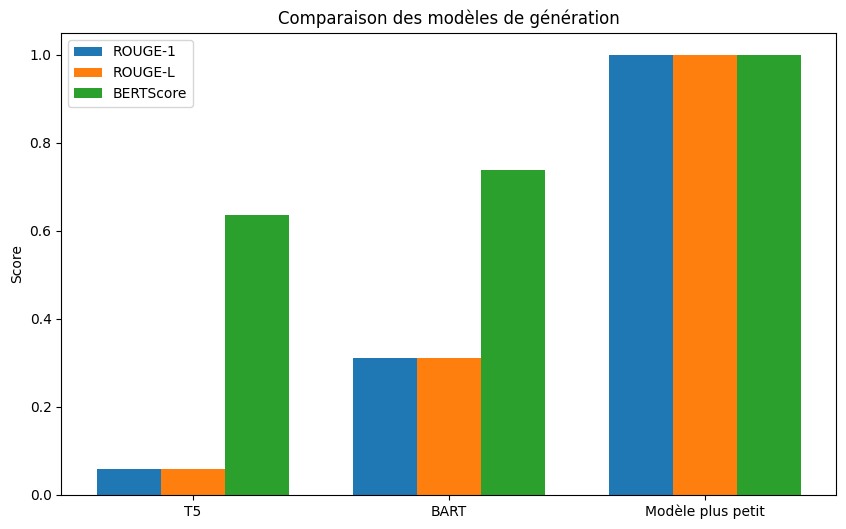

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration, BartForConditionalGeneration
from transformers import pipeline as hf_pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.llms import HuggingFacePipeline
from langchain_core.output_parsers import StrOutputParser

# Fonction utilitaire pour extraire le contexte à partir des documents récupérés
def get_context_from_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

# Modèle 1: T5
def generate_with_t5(query, context, model_name="google/flan-t5-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    prompt = f"Contexte: {context}\n\nQuestion: {query}\n\nRéponse:"
    input_ids = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).input_ids

    outputs = model.generate(
        input_ids=input_ids,
        max_length=512,
        num_beams=4,
        temperature=0.7,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Modèle 2: BART
def generate_with_bart(query, context, model_name="facebook/bart-large-cnn"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)

    prompt = f"Contexte: {context}\n\nQuestion: {query}\n\nRéponse:"
    input_ids = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).input_ids

    outputs = model.generate(
        input_ids=input_ids,
        max_length=512,
        num_beams=4,
        temperature=0.7,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Modèle 3: Version plus petite du même type de modèle pour éviter les problèmes de mémoire
def generate_with_small_model(query, context, model_name="facebook/bart-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    prompt = f"Contexte: {context}\n\nQuestion: {query}\n\nRéponse:"
    input_ids = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).input_ids

    outputs = model.generate(
        input_ids=input_ids,
        max_length=512,
        num_beams=3,
        temperature=0.8,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Fonction d'évaluation des réponses générées
def evaluate_generation(reference, generated):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated)

    # BLEU
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu([reference.split()], generated.split(), smoothing_function=smoothie)

    # BERTScore
    P, R, F1 = score([generated], [reference], lang="fr", verbose=False)
    bert_score = F1.item()

    return {
        "rouge1": rouge_scores['rouge1'].fmeasure,
        "rouge2": rouge_scores['rouge2'].fmeasure,
        "rougeL": rouge_scores['rougeL'].fmeasure,
        "bleu": bleu_score,
        "bert_score": bert_score
    }

# Test des modèles avec des questions de test
test_questions = [
    "Quel est le sujet principal abordé dans ces documents?",
    "Résumez les points clés mentionnés dans le texte.",
    "Quelles sont les conclusions importantes présentées dans ces documents?"
]

# Pour un test plus rapide, utilisez un seul exemple
test_questions = [test_questions[0]]  # Décommentez cette ligne pour tester avec la première question seulement

for question in test_questions:
    print(f"\nQuestion: {question}")

    # Récupérer le contexte
    docs = final_retriever.get_relevant_documents(question)
    context = get_context_from_docs(docs)

    # Pour éviter des contextes trop longs qui pourraient causer des problèmes
    if len(context) > 5000:
        context = context[:5000] + "..."

    # Générer des réponses avec les différents modèles
    try:
        print("Génération avec T5...")
        t5_response = generate_with_t5(question, context)
        print("Génération avec BART...")
        bart_response = generate_with_bart(question, context)
        print("Génération avec modèle plus petit...")
        small_model_response = generate_with_small_model(question, context)

        print(f"\nRéponse T5:\n{t5_response}")
        print(f"\nRéponse BART:\n{bart_response}")
        print(f"\nRéponse modèle plus petit:\n{small_model_response}")

        # Évaluation comparative des réponses
        # Nous utilisons la réponse la plus longue comme référence artificielle pour cette démonstration
        reference = max([t5_response, bart_response, small_model_response], key=len)

        t5_scores = evaluate_generation(reference, t5_response)
        bart_scores = evaluate_generation(reference, bart_response)
        small_model_scores = evaluate_generation(reference, small_model_response)

        print("\nÉvaluation (scores par rapport à la référence):")
        print(f"T5: ROUGE-1 = {t5_scores['rouge1']:.3f}, ROUGE-L = {t5_scores['rougeL']:.3f}, BLEU = {t5_scores['bleu']:.3f}, BERTScore = {t5_scores['bert_score']:.3f}")
        print(f"BART: ROUGE-1 = {bart_scores['rouge1']:.3f}, ROUGE-L = {bart_scores['rougeL']:.3f}, BLEU = {bart_scores['bleu']:.3f}, BERTScore = {bart_scores['bert_score']:.3f}")
        print(f"Modèle plus petit: ROUGE-1 = {small_model_scores['rouge1']:.3f}, ROUGE-L = {small_model_scores['rougeL']:.3f}, BLEU = {small_model_scores['bleu']:.3f}, BERTScore = {small_model_scores['bert_score']:.3f}")

        # Visualisation des scores
        models = ['T5', 'BART', 'Modèle plus petit']
        rouge1_scores = [t5_scores['rouge1'], bart_scores['rouge1'], small_model_scores['rouge1']]
        rougeL_scores = [t5_scores['rougeL'], bart_scores['rougeL'], small_model_scores['rougeL']]
        bert_scores = [t5_scores['bert_score'], bart_scores['bert_score'], small_model_scores['bert_score']]

        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.arange(len(models))
        width = 0.25

        ax.bar(x - width, rouge1_scores, width, label='ROUGE-1')
        ax.bar(x, rougeL_scores, width, label='ROUGE-L')
        ax.bar(x + width, bert_scores, width, label='BERTScore')

        ax.set_ylabel('Score')
        ax.set_title('Comparaison des modèles de génération')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()

        plt.show()

    except Exception as e:
        print(f"Erreur lors de la génération ou évaluation des réponses: {e}")
        print("Essayons avec un contexte plus court...")

        # Réessayer avec un contexte plus court en cas d'erreur
        context = context[:2000] + "..."

        try:
            print("Génération avec T5 (contexte réduit)...")
            t5_response = generate_with_t5(question, context)
            print(f"\nRéponse T5 (contexte réduit):\n{t5_response}")
        except Exception as e2:
            print(f"Erreur même avec contexte réduit: {e2}")

In [ ]:
# Interface simple pour tester le système RAG
from IPython.display import clear_output

def rag_qa_system():
    # Fonction pour obtenir une réponse avec le pipeline complet
    def get_answer(question, model_type="t5"):
        # Récupérer les documents pertinents
        docs = final_retriever.get_relevant_documents(question)
        context = get_context_from_docs(docs)

        # Limiter la taille du contexte pour éviter les erreurs
        if len(context) > 4000:
            context = context[:4000] + "..."

        # Générer la réponse selon le modèle choisi
        if model_type == "t5":
            answer = generate_with_t5(question, context)
        elif model_type == "bart":
            answer = generate_with_bart(question, context)
        elif model_type == "small":
            answer = generate_with_small_model(question, context)
        else:
            return "Modèle non reconnu"

        return {
            "answer": answer,
            "context": context,
            "source_docs": docs
        }

    # Interface utilisateur
    print("=== Système de Questions-Réponses avec RAG ===")
    print("Entrez votre question ou 'q' pour quitter")

    while True:
        question = input("\nVotre question: ")
        if question.lower() == 'q':
            break

        model_choice = input("Choisissez un modèle (t5/bart/small/tous): ")

        if model_choice.lower() == "tous":
            # Exécuter tous les modèles
            print("\nRecherche de contexte pertinent...")
            t5_results = get_answer(question, "t5")
            bart_results = get_answer(question, "bart")
            small_results = get_answer(question, "small")

            print("\n=== Résultats comparatifs ===")
            print(f"\nRéponse T5:\n{t5_results['answer']}")
            print(f"\nRéponse BART:\n{bart_results['answer']}")
            print(f"\nRéponse modèle plus petit:\n{small_results['answer']}")

            # Évaluation comparative des réponses
            # Nous utilisons la réponse la plus longue comme référence artificielle
            answers = [t5_results['answer'], bart_results['answer'], small_results['answer']]
            reference = max(answers, key=len)

            t5_scores = evaluate_generation(reference, t5_results['answer'])
            bart_scores = evaluate_generation(reference, bart_results['answer'])
            small_scores = evaluate_generation(reference, small_results['answer'])

            print("\nÉvaluation (scores par rapport à la référence):")
            print(f"T5: ROUGE-1 = {t5_scores['rouge1']:.3f}, BERTScore = {t5_scores['bert_score']:.3f}")
            print(f"BART: ROUGE-1 = {bart_scores['rouge1']:.3f}, BERTScore = {bart_scores['bert_score']:.3f}")
            print(f"Modèle plus petit: ROUGE-1 = {small_scores['rouge1']:.3f}, BERTScore = {small_scores['bert_score']:.3f}")

            # Afficher une partie du contexte utilisé
            print(f"\nContexte utilisé (extrait):\n{t5_results['context'][:500]}...")

        else:
            # Exécuter un seul modèle
            print("\nRecherche de contexte pertinent...")
            results = get_answer(question, model_choice.lower())

            print(f"\nRéponse:\n{results['answer']}")
            print(f"\nContexte utilisé (extrait):\n{results['context'][:500]}...")

    print("Au revoir!")

# Exécuter l'interface
rag_qa_system()

=== Système de Questions-Réponses avec RAG ===
Entrez votre question ou 'q' pour quitter

Votre question: l'operation due diligence
Choisissez un modèle (t5/bart/small/tous): t5

Recherche de contexte pertinent...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Réponse:
may include adjustments or potential adjustments to purchase price, changes to the acquisition contract (e.g., reps, disclosure, covenants, conditions, termination provisions, indemnities), modifications of transaction structure and/or adjustments to the roadmap

Contexte utilisé (extrait):
C O N C L U S I O N

Depending on the outcomes of a diligence exercise, acquiring institutions and investors may need to 
make adjustments to their plans. The implications of due diligence findings may include adjustments  
or potential adjustments to purchase price, changes to the acquisition contract (e.g., reps, disclosure, 
covenants, conditions, termination provisions, indemnities), modifications of transaction structure  
and/or adjustments to the roadmap for integration and post-closing o...
